In [6]:
import sys
sys.path.append('utils/')

import pandas as pd
import numpy as np
# I have in utils/ the file Metrica_IO and i want to import it
from utils import Metrica_IO as mio
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [2]:
DATA_DIR= "data/"
game_id=2
home_xy, away_xy, events =mio.read_match_data(DATA_DIR,game_id)

# Change the coordinates to have the origin in the center of the field
home_xy=mio.to_metric_coordinates(home_xy)
away_xy=mio.to_metric_coordinates(away_xy)
events=mio.to_metric_coordinates(events)

Reading team: home
Reading team: away


In [3]:
hulls_df=pd.read_csv("data/hulls_df.csv")

In [7]:
from hmmlearn import hmm

X = np.log(hulls_df["HomeHull"].to_numpy())
Y = np.log(hulls_df["AwayHull"].to_numpy())

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=1234)
model1 = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=1234)

In [8]:
model.fit(X.reshape(-1,1))
model1.fit(Y.reshape(-1,1))

GaussianHMM(n_components=2, n_iter=100, random_state=1234)


Gaussian distribution means:
[[6.77248145]
 [5.51125306]]

Gaussian distribution covariances:
[[[0.07331952]]

 [[0.88470772]]]

Start probabilities:
[1. 0.]

Transition matrix:
[[1. 0.]
 [0. 1.]]


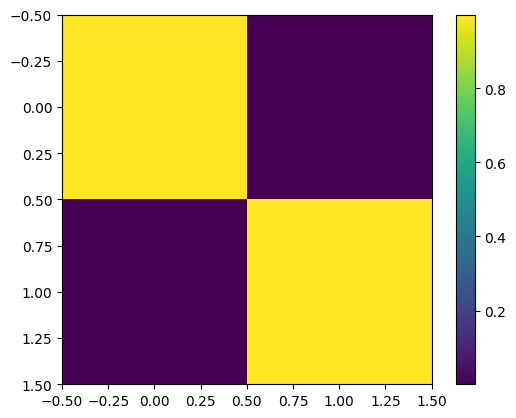

In [9]:
print("\nGaussian distribution means:")
print(model.means_)

print("\nGaussian distribution covariances:")
print(model.covars_)

print("\nStart probabilities:")
print(np.round(model.startprob_, 2))

print("\nTransition matrix:")
print(np.round(model.transmat_,2))

_ = plt.imshow(model.transmat_)
_ = plt.colorbar()


Gaussian distribution means:
[[6.87209986]
 [5.75566136]]

Gaussian distribution covariances:
[[[0.07663095]]

 [[0.59552705]]]

Start probabilities:
[1. 0.]

Transition matrix:
[[1. 0.]
 [0. 1.]]


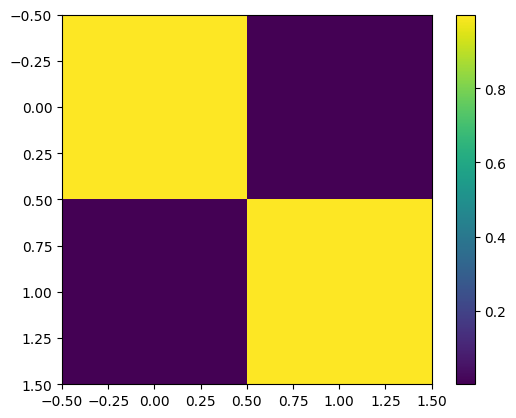

In [10]:
print("\nGaussian distribution means:")
print(model1.means_)

print("\nGaussian distribution covariances:")
print(model1.covars_)

print("\nStart probabilities:")
print(np.round(model1.startprob_, 2))

print("\nTransition matrix:")
print(np.round(model1.transmat_,2))

_ = plt.imshow(model1.transmat_)
_ = plt.colorbar()

In [60]:
import numpy as np
from scipy.stats import gamma
from hmmlearn.base import _BaseHMM
from hmmlearn.utils import normalize

class GammaHMM(_BaseHMM):
    def __init__(self, n_components=1, alpha=1.0, beta=1.0, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        self.alpha = np.full(n_components, alpha)
        self.beta = np.full(n_components, beta)
        
    def _compute_log_likelihood(self, X):
        X = X.flatten()  # Ensure X is one-dimensional
        log_prob = np.empty((X.shape[0], self.n_components))
        for i in range(self.n_components):
            log_prob[:, i] = gamma.logpdf(X, self.alpha[i], scale=self.beta[i])
        return log_prob
    
    def _generate_sample_from_state(self, state, random_state=None):
        if random_state is None:
            random_state = np.random.RandomState()
        return gamma.rvs(self.alpha[state], scale=self.beta[state], random_state=random_state)
    
    def _init(self, X, lengths=None):
        n_samples, _ = X.shape
        self.startprob_ = np.full(self.n_components, 1.0 / self.n_components)
        self.transmat_ = np.full((self.n_components, self.n_components), 1.0 / self.n_components)
        
    def _initialize_sufficient_statistics(self):
        stats = super()._initialize_sufficient_statistics()
        stats['post_comp'] = np.zeros((self.n_components,))
        stats['post_obs'] = np.zeros((self.n_components,))
        stats['post_obs_sq'] = np.zeros((self.n_components,))
        return stats
    
    def _accumulate_sufficient_statistics(self, stats, X, framelogprob, posteriors, fwdlattice, bwdlattice):
        super()._accumulate_sufficient_statistics(stats, X, framelogprob, posteriors, fwdlattice, bwdlattice)
        stats['post_comp'] += posteriors.sum(axis=0)
        stats['post_obs'] += np.dot(posteriors.T, X.flatten())
        stats['post_obs_sq'] += np.dot(posteriors.T, X.flatten()**2)
    
    def _do_mstep(self, stats):
        super()._do_mstep(stats)
        # Re-estimate the parameters of the Gamma distribution
        for i in range(self.n_components):
            mean = stats['post_obs'][i] / stats['post_comp'][i]
            mean_sq = stats['post_obs_sq'][i] / stats['post_comp'][i]
            variance = mean_sq - mean**2
            self.alpha[i] = mean ** 2 / variance**2
            self.beta[i] = variance**2 / mean

In [58]:
X = hulls_df["home_hull"].to_numpy()
Y = hulls_df["away_hull"].to_numpy()

model = GammaHMM(n_components=2, n_iter=100)
model1 = GammaHMM(n_components=2, n_iter=100)

model.fit(X.reshape(-1,1))
model1.fit(Y.reshape(-1,1))

GammaHMM(alpha=array([3.42719531e-05, 3.42719531e-05]),
         beta=array([24376911.08877853, 24376911.08877853]), n_components=2)


Start probabilities:
[0.5 0.5]

Transition matrix:
[[0.5 0.5]
 [0.5 0.5]]


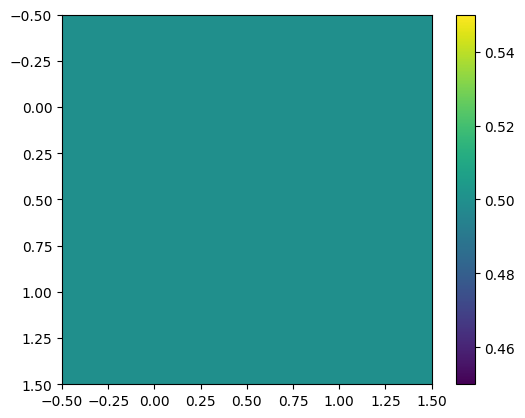

In [56]:


print("\nStart probabilities:")
print(np.round(model.startprob_, 2))

print("\nTransition matrix:")
print(np.round(model.transmat_,2))

_ = plt.imshow(model.transmat_)
_ = plt.colorbar()